In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch.nn as nn
from torchvision import datasets,transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.fft import fftshift,fft2

from conv_layers import *
from main_net import *
from wavelet_net import *
from encoder_decoder import *
from decoder_arch_net import *
from model_optimization import *
from model_evaluation import *

image_size = 32

    
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(123);


ConvOnly_model.pt with MNIST data is already trained and saved, delete the file Models/MNIST/ConvOnly_model.pt to retrain the model 

FullyConnected_model.pt with MNIST data is already trained and saved, delete the file Models/MNIST/FullyConnected_model.pt to retrain the model 

UnalignedData_FullyConnected_model.pt with MNIST data is already trained and saved, delete the file Models/MNIST/UnalignedData_FullyConnected_model.pt to retrain the model 

UnalignedData_RotTransInvar_FullyConnected_model.pt with MNIST data is already trained and saved, delete the file Models/MNIST/UnalignedData_RotTransInvar_FullyConnected_model.pt to retrain the model 

Wavelet_model.pt with MNIST data is already trained and saved, delete the file Models/MNIST/Wavelet_model.pt to retrain the model 

WaveletPacket_model.pt with MNIST data is already trained and saved, delete the file Models/MNIST/WaveletPacket_model.pt to retrain the model 

ED_model.pt with MNIST data is already trained and saved, delete the

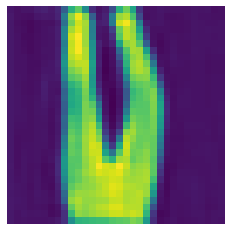

In [2]:
#Train all models for each dataset
data_names = ['MNIST','Fashion-MNIST']
model_names = ['ConvOnly_model','FullyConnected_model',
              'UnalignedData_FullyConnected_model','UnalignedData_RotTransInvar_FullyConnected_model'
              ,'Wavelet_model','WaveletPacket_model','DecoderArch_model']
models_invar_rot = [False,False,True,True,True,True,True]
models_invar_translation = [False,False,True,True,False,False,False]
models_performance = {}

for data_name in data_names:
    
    train_loader = load_DATASET(data_name,"train",image_size,batch_size = 32, random_transform_enabled = False)
    test_loader = load_DATASET(data_name, "test",image_size,batch_size = 32, random_transform_enabled = False)

    conv_model = Net(image_size,[],[3,5,5,1]).to(device)
    train_save_model(model_names[0],data_name,conv_model,device,train_loader,test_loader,epoch_num=50,learning_rate = 5e-5)

    model = Net(image_size,[512 ,256,512, image_size**2],[3,5,1])
    train_save_model(model_names[1],data_name,model,device,train_loader,test_loader,epoch_num = 50,learning_rate=5e-5)
    
    #Train models with unaligned data
    unaligned_train_loader = randomMisalignedData(load_DATASET(data_name,"train",image_size,batch_size = 32, random_transform_enabled = True))
    unaliged_test_loader = randomMisalignedData(load_DATASET(data_name,"test",image_size,batch_size = 32, random_transform_enabled = True))
    
    
    model = Net(image_size,[512 ,256,512,image_size**2],[3,5,1])
    train_save_model(model_names[2],data_name,model,device,unaligned_train_loader,unaliged_test_loader,epoch_num = 50, learning_rate = 0.001)
    
    
    model = Net(image_size,[512 ,256,512,image_size**2],[3,5,1],loss=CrossCorrelation_MagnitudeMSE)
    train_save_model(model_names[3],data_name,model,device,unaligned_train_loader,unaliged_test_loader,epoch_num = 50, learning_rate = 0.001)
    
    
    wavelet_model = waveletNet(image_size,[512,256,512,image_size**2],[64,128,256,64],rep_loss_lambda=1,rot180=True,packet_transform = False)
    train_save_model(model_names[4],data_name,wavelet_model,device,train_loader,test_loader,epoch_num = 50,learning_rate = 5e-5)

    wavelet_model = waveletNet(image_size,[512,256,512,image_size**2],[64,128,256,64],rep_loss_lambda=1,rot180=True,packet_transform = True)
    train_save_model(model_names[5],data_name,wavelet_model,device,train_loader,test_loader,epoch_num = 50,learning_rate = 5e-5)

    #Create new data loaders for encoder-decoder net for which the target is the same as the data
    encoder_train_loader = load_DATASET(data_name,"train",image_size,batch_size = 32, random_transform_enabled = False)
    encoder_train_loader.dataset.data = encoder_train_loader.dataset.targets   
    encoder_test_loader = load_DATASET(data_name,"test",image_size,batch_size = 32, random_transform_enabled = False)
    encoder_test_loader.dataset.data = encoder_test_loader.dataset.targets

    
    ch_size = 8
    ch_num = 64
    ED_model = EncoderDecoderNet(image_size = image_size,ch_num=ch_num,conv_blocks=3,l1_loss_lambda=5e-7)
    train_save_model('ED_model',data_name,ED_model,device,encoder_train_loader,encoder_test_loader,epoch_num = 50,learning_rate = 5e-5)
  
    img_dim = image_size**2
    ED_model = loadModel('ED_model.pt',data_name = data_name)
    model = DecoderArchNet(image_size,[img_dim,img_dim,img_dim,ch_num*ch_size**2],[64,128,256,64],ED_model.encoder,ED_model.decoder,rep_loss_lambda=1,rot180 = True)
    train_save_model(model_names[6],data_name,model,device,train_loader,test_loader,epoch_num=50,learning_rate=5e-5)

    
    
    performance_table = pd.DataFrame()
    for i,model_name in enumerate(model_names):
        if('UnalignedData' in model_name):
            me = ModelEvaluation(model_name,data_name,models_invar_rot[i],models_invar_translation[i],test_loader = unaliged_test_loader)
        else:
            me = ModelEvaluation(model_name,data_name,models_invar_rot[i],models_invar_translation[i])
        performance_table = performance_table.append(me.performance_metrics(),ignore_index=True)
        me.save_example_images()
    
    performance_table.index = model_names
    models_performance[data_name] = performance_table
    
    models_performance[data_name].to_csv(join('out',data_name,'results.csv'))
    
print(models_performance[data_names[0]])
print(models_performance[data_names[1]])

(-0.5, 31.5, 31.5, -0.5)

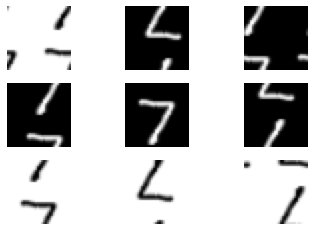

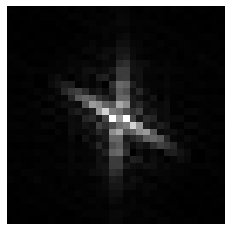

In [53]:
#Example Figure - Invariance of Fourier amplitudes to circular shift, rotation by 180, flipping pixel values:
import random
test_loader = load_DATASET("MNIST", "test",image_size,batch_size = 32, random_transform_enabled = False)
img = test_loader.dataset.targets[0].view(image_size,image_size)
img_dups = img.repeat((9,1,1))

fig,axs = plt.subplots(3,3)

for i in range(img_dups.size(0)):
    if(i != 4):
        img_dups[i] = torch.roll(img_dups[i],(random.randint(0,image_size),random.randint(0,image_size)),dims=(0,1))
        if(random.random() < 0.5):
            img_dups[i] = torch.rot90(img_dups[i],2,dims=(0,1))

        if(random.random() < 0.5):
            img_dups[i] = -img_dups[i]
        
    axs[int(i/3),i%3].imshow(img_dups[i],cmap='gray')
    axs[int(i/3),i%3].axis('off')
    
plt.figure()       
plt.imshow(test_loader.dataset.data[0],cmap = 'gray')    
plt.axis('off')


torch.Size([128, 128])


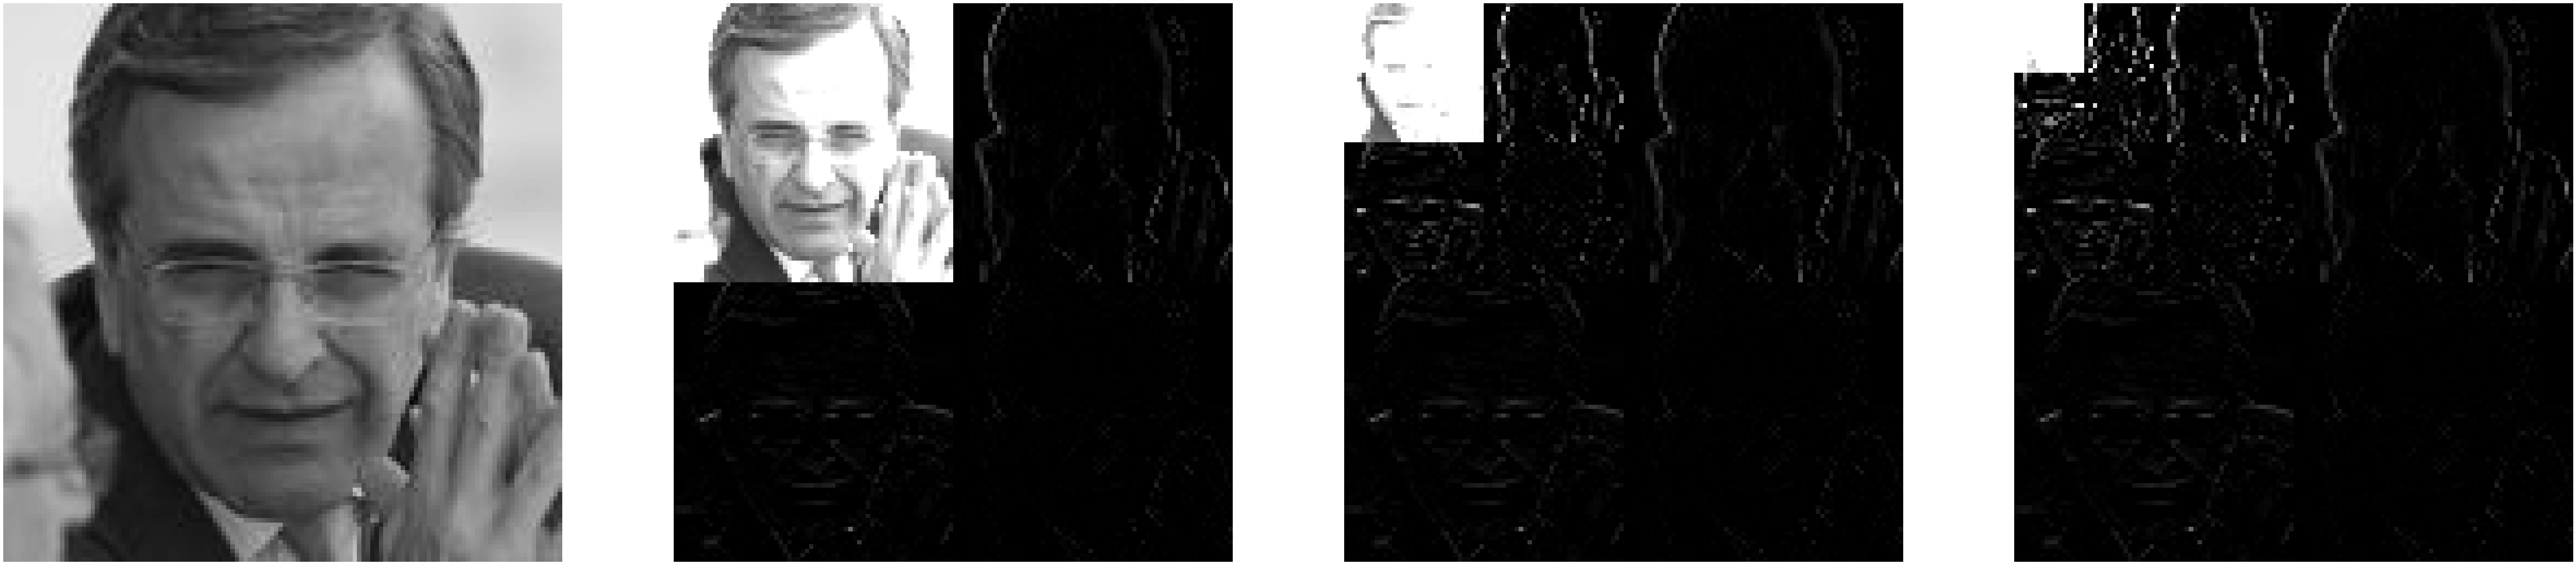

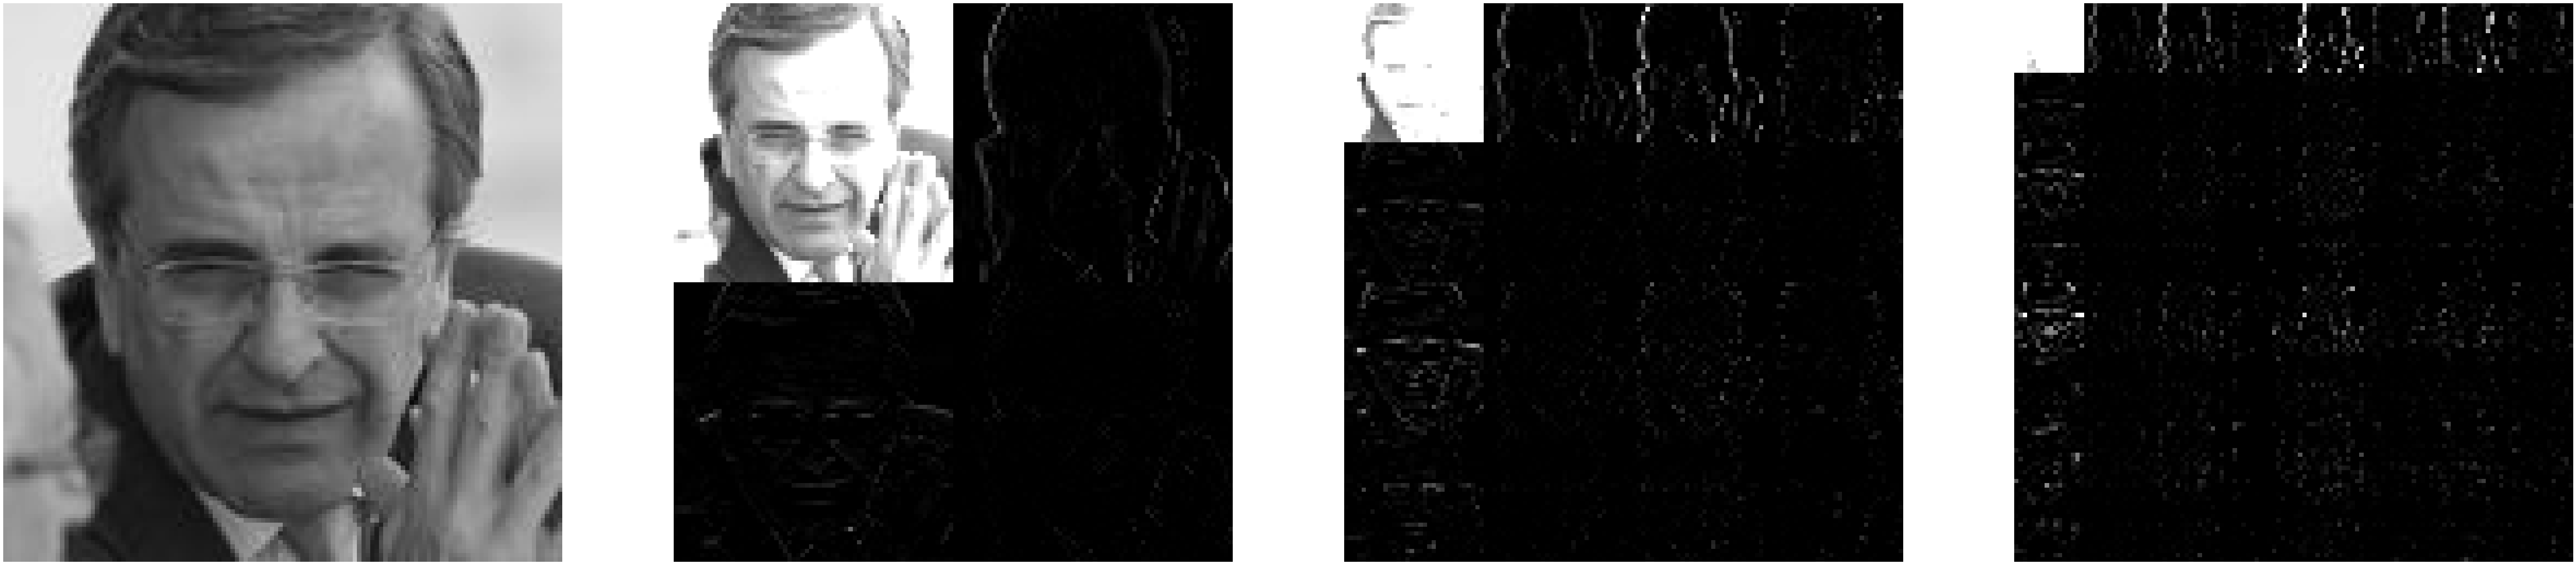

In [75]:
from PIL import Image
import torch
import torchvision.transforms as transforms

image = Image.open('out/example.png')

t = transforms.Compose([transforms.PILToTensor()])

img_tensor = torch.mean((t(image)).float(),dim=(0))/255
image_size = 128
imgs = img_tensor.view(1,image_size,image_size)
N = 1

print(img_tensor.shape)

fig,axs = plt.subplots(1,4)
fig.set_figwidth(100)
fig.set_figheight(25)

for i in range(4):
    if(i == 0):
        imgs_wavelet = imgs
    else:
        wavelet_layer = DWTLayer(image_size,J=i)
        imgs_wavelet = wavelet_layer(imgs).view(N,image_size,image_size)

    
    axs[i].imshow(imgs_wavelet[0],cmap='gray',vmin=0,vmax=1)
    axs[i].axis('off')

    
    
    
fig,axs = plt.subplots(1,4)
fig.set_figwidth(100)
fig.set_figheight(25)

wavelet_layer = DWTLayer(image_size,J=1)
for i in range(4):
    if(i == 0):
        imgs_wavelet = imgs
    else:
        imgs_wavelet = wavelet_layer(imgs_wavelet).view(N,image_size,image_size)

    
    axs[i].imshow(imgs_wavelet[0],cmap='gray',vmin=0,vmax=1)
    axs[i].axis('off')


    